### Comparison of optimizers for LASSO parameter range experiments

sklearn has 2 ways to fit logistic regression models with a LASSO penalty: [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) (using the liblinear optimizer; i.e. coordinate descent), and [SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) (which uses stochastic gradient descent).

Here, we want to compare mutation prediction results between the two optimizers, across all the cancer genes in our driver gene set.

In [1]:
import os
import itertools as it

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
import seaborn as sns

import pancancer_evaluation.config as cfg
import pancancer_evaluation.utilities.data_utilities as du
import pancancer_evaluation.utilities.analysis_utilities as au

%load_ext autoreload
%autoreload 2

In [2]:
ll_base_results_dir = os.path.join(
    cfg.repo_root, '02_cancer_type_classification', 'results', 'lasso_range_lr_all_features'
)

# this doesn't have a sex covariate but it's probably close enough
sgd_base_results_dir = os.path.join(
    cfg.repo_root, '02_cancer_type_classification', 'results', 'lasso_range_valid'
)

training_dataset = 'all_other_cancers'
ll_results_dir = os.path.join(ll_base_results_dir, training_dataset)
sgd_results_dir = os.path.join(sgd_base_results_dir, training_dataset)

metric = 'aupr'
data_type = 'cv'

### Get coefficient information for each lasso penalty

In [3]:
# these are generated from results files pretty slowly so it helps to cache them
ll_coefs_df_file = './ll_coefficients_df.tsv'

if os.path.exists(ll_coefs_df_file):
    print('df exists')
    ll_nz_coefs_df = pd.read_csv(ll_coefs_df_file, sep='\t', index_col=0)
else:
    ll_nz_coefs_df = []
    # get coefficient info for training dataset specified above
    for coef_info in au.generate_nonzero_coefficients_lasso_range(ll_results_dir):
        (gene,
         cancer_type,
         seed,
         lasso_param,
         coefs_list) = coef_info
        for fold_no, coefs in enumerate(coefs_list):
            ll_nz_coefs_df.append(
                [gene, cancer_type, lasso_param, seed, fold_no, len(coefs)]
            )
    ll_nz_coefs_df = pd.DataFrame(
        ll_nz_coefs_df,
        columns=['gene', 'cancer_type', 'lasso_param', 'seed', 'fold', 'nz_coefs']
    )
    ll_nz_coefs_df.lasso_param = ll_nz_coefs_df.lasso_param.astype(float)
    ll_nz_coefs_df.to_csv(ll_coefs_df_file, sep='\t')
                                                                  
ll_nz_coefs_df.head()

df exists


,gene,cancer_type,lasso_param,seed,fold,nz_coefs
0,MAP3K1,BRCA,1.0,1,0,113
1,MAP3K1,BRCA,1.0,1,1,113
2,MAP3K1,BRCA,1.0,1,2,132
3,MAP3K1,BRCA,1.0,1,3,128
4,MAP3K1,UCEC,2000.0,42,0,8788


In [4]:
# these are generated from results files pretty slowly so it helps to cache them
sgd_coefs_df_file = './sgd_coefficients_df.tsv'

if os.path.exists(sgd_coefs_df_file):
    print('df exists')
    sgd_nz_coefs_df = pd.read_csv(sgd_coefs_df_file, sep='\t', index_col=0)
else:
    sgd_nz_coefs_df = []
    # get coefficient info for training dataset specified above
    for coef_info in au.generate_nonzero_coefficients_lasso_range(sgd_results_dir):
        (gene,
         cancer_type,
         seed,
         lasso_param,
         coefs_list) = coef_info
        for fold_no, coefs in enumerate(coefs_list):
            sgd_nz_coefs_df.append(
                [gene, cancer_type, lasso_param, seed, fold_no, len(coefs)]
            )
    sgd_nz_coefs_df = pd.DataFrame(
        sgd_nz_coefs_df,
        columns=['gene', 'cancer_type', 'lasso_param', 'seed', 'fold', 'nz_coefs']
    )
    sgd_nz_coefs_df.lasso_param = sgd_nz_coefs_df.lasso_param.astype(float)
    sgd_nz_coefs_df.to_csv(sgd_coefs_df_file, sep='\t')
                                                                  
sgd_nz_coefs_df.head()

df exists


,gene,cancer_type,lasso_param,seed,fold,nz_coefs
0,MAP3K1,UCEC,0.0025,42,0,5700
1,MAP3K1,UCEC,0.0025,42,1,5878
2,MAP3K1,UCEC,0.0025,42,2,4785
3,MAP3K1,UCEC,0.0025,42,3,5396
4,MAP3K1,BRCA,0.0001,1,0,7919


### Get performance information for each lasso penalty

In [5]:
# load performance information
ll_perf_df_file = './ll_perf_df.tsv'

if os.path.exists(ll_perf_df_file):
    print('df exists')
    ll_perf_df = pd.read_csv(ll_perf_df_file, sep='\t', index_col=0)
else:
    ll_perf_df = au.load_prediction_results_lasso_range(ll_results_dir,
                                                        'liblinear')
    ll_perf_df.rename(columns={'experiment': 'optimizer'}, inplace=True)
    ll_perf_df.lasso_param = ll_perf_df.lasso_param.astype(float)
    ll_perf_df.to_csv(ll_perf_df_file, sep='\t')

ll_perf_df.head()

df exists


,auroc,aupr,gene,holdout_cancer_type,signal,seed,data_type,fold,optimizer,lasso_param
0,1.00000,1.000000,MAP3K1,BRCA,signal,1,train,0,liblinear,1.0
1,0.43147,0.062268,MAP3K1,BRCA,signal,1,test,0,liblinear,1.0
2,0.49347,0.062197,MAP3K1,BRCA,signal,1,cv,0,liblinear,1.0
3,1.00000,1.000000,MAP3K1,BRCA,signal,1,train,1,liblinear,1.0
4,0.36746,0.084355,MAP3K1,BRCA,signal,1,test,1,liblinear,1.0


In [6]:
# add nonzero coefficient count
ll_plot_df = (
    ll_perf_df[(ll_perf_df.signal == 'signal')]
      .merge(ll_nz_coefs_df, left_on=['holdout_cancer_type', 'lasso_param', 'seed', 'fold'],
             right_on=['cancer_type', 'lasso_param', 'seed', 'fold'])
      .drop(columns=['cancer_type', 'gene_y'])
      .rename(columns={'gene_x': 'gene'})
      .sort_values(by=['holdout_cancer_type', 'lasso_param'])
      .reset_index(drop=True)
)
ll_plot_df.lasso_param = ll_plot_df.lasso_param.astype(float)

print(ll_plot_df.shape)
ll_plot_df.head()

(1871040, 11)


,auroc,aupr,gene,holdout_cancer_type,signal,seed,data_type,fold,optimizer,lasso_param,nz_coefs
0,0.5,0.47534,TP53,BLCA,signal,1,train,0,liblinear,0.001,0
1,0.5,0.47534,TP53,BLCA,signal,1,train,0,liblinear,0.001,0
2,0.5,0.47534,TP53,BLCA,signal,1,train,0,liblinear,0.001,0
3,0.5,0.47534,TP53,BLCA,signal,1,train,0,liblinear,0.001,0
4,0.5,0.47534,TP53,BLCA,signal,1,train,0,liblinear,0.001,0


In [7]:
# load performance information
sgd_perf_df_file = './sgd_perf_df.tsv'

if os.path.exists(sgd_perf_df_file):
    print('df exists')
    sgd_perf_df = pd.read_csv(sgd_perf_df_file, sep='\t', index_col=0)
else:
    sgd_perf_df = au.load_prediction_results_lasso_range(sgd_results_dir,
                                                        'sgd')
    sgd_perf_df.rename(columns={'experiment': 'optimizer'}, inplace=True)
    sgd_perf_df.lasso_param = sgd_perf_df.lasso_param.astype(float)
    sgd_perf_df.to_csv(sgd_perf_df_file, sep='\t')

sgd_perf_df.head()

df exists


,auroc,aupr,gene,holdout_cancer_type,signal,seed,data_type,fold,optimizer,lasso_param
0,0.99956,0.993810,MAP3K1,BRCA,signal,1,train,0,sgd,0.0025
1,0.47505,0.072132,MAP3K1,BRCA,signal,1,test,0,sgd,0.0025
2,0.50840,0.061408,MAP3K1,BRCA,signal,1,cv,0,sgd,0.0025
3,0.99648,0.942830,MAP3K1,BRCA,signal,1,train,1,sgd,0.0025
4,0.46982,0.100750,MAP3K1,BRCA,signal,1,test,1,sgd,0.0025


In [8]:
# add nonzero coefficient count
sgd_plot_df = (
    sgd_perf_df[(sgd_perf_df.signal == 'signal')]
      .merge(sgd_nz_coefs_df, left_on=['holdout_cancer_type', 'lasso_param', 'seed', 'fold'],
             right_on=['cancer_type', 'lasso_param', 'seed', 'fold'])
      .drop(columns=['cancer_type', 'gene_y'])
      .rename(columns={'gene_x': 'gene'})
      .sort_values(by=['holdout_cancer_type', 'lasso_param'])
      .reset_index(drop=True)
)
sgd_plot_df.lasso_param = sgd_plot_df.lasso_param.astype(float)

print(sgd_plot_df.shape)
sgd_plot_df.head()

(1169400, 11)


,auroc,aupr,gene,holdout_cancer_type,signal,seed,data_type,fold,optimizer,lasso_param,nz_coefs
0,0.99994,0.99993,TP53,BLCA,signal,1,train,0,sgd,0.0001,7408
1,0.99994,0.99993,TP53,BLCA,signal,1,train,0,sgd,0.0001,7648
2,0.99994,0.99993,TP53,BLCA,signal,1,train,0,sgd,0.0001,7847
3,0.99994,0.99993,TP53,BLCA,signal,1,train,0,sgd,0.0001,7846
4,0.99994,0.99993,TP53,BLCA,signal,1,train,0,sgd,0.0001,7571


In [9]:
all_perf_df = pd.concat((ll_plot_df, sgd_plot_df)).reset_index(drop=True)

print(all_perf_df.shape)
print(all_perf_df.optimizer.unique())
all_perf_df.head()

(3040440, 11)
['liblinear' 'sgd']


,auroc,aupr,gene,holdout_cancer_type,signal,seed,data_type,fold,optimizer,lasso_param,nz_coefs
0,0.5,0.47534,TP53,BLCA,signal,1,train,0,liblinear,0.001,0
1,0.5,0.47534,TP53,BLCA,signal,1,train,0,liblinear,0.001,0
2,0.5,0.47534,TP53,BLCA,signal,1,train,0,liblinear,0.001,0
3,0.5,0.47534,TP53,BLCA,signal,1,train,0,liblinear,0.001,0
4,0.5,0.47534,TP53,BLCA,signal,1,train,0,liblinear,0.001,0


### Select best lasso parameter for each optimizer

We'll do this for both CV (validation) datasets and test (holdout cancer type) datasets.

In [10]:
# get mean AUPR values across folds/seeds
ll_mean_aupr_df = (
    all_perf_df[(all_perf_df.data_type == data_type) &
                (all_perf_df.optimizer == 'liblinear')]
      .drop(columns=['data_type', 'optimizer'])
      .groupby(['gene', 'holdout_cancer_type', 'lasso_param'])
      .agg(np.mean)
      .reset_index()
      .drop(columns=['seed', 'fold', 'auroc', 'nz_coefs'])
)

# get best LASSO parameter by mean AUPR, across all the ones we tried for this optimizer
ll_max_lasso_ix = (ll_mean_aupr_df
      .groupby(['gene', 'holdout_cancer_type'])
      .aupr.idxmax()
)
ll_max_lasso_param_df = ll_mean_aupr_df.loc[ll_max_lasso_ix, :]

print(ll_max_lasso_param_df.shape)
ll_max_lasso_param_df.head(8)

(278, 4)


,gene,holdout_cancer_type,lasso_param,aupr
2,APC,BLCA,0.010,0.839074
18,APC,COAD,0.010,0.592498
34,APC,LUAD,0.010,0.815967
50,APC,LUSC,0.010,0.824568
66,APC,READ,0.010,0.718029
82,APC,SKCM,0.010,0.821822
97,APC,STAD,0.005,0.813326
116,ARID1A,BLCA,0.100,0.590499


In [11]:
# get mean AUPR values across folds/seeds
sgd_mean_aupr_df = (
    all_perf_df[(all_perf_df.data_type == data_type) &
                (all_perf_df.optimizer == 'sgd')]
      .drop(columns=['data_type', 'optimizer'])
      .groupby(['gene', 'holdout_cancer_type', 'lasso_param'])
      .agg(np.mean)
      .reset_index()
      .drop(columns=['seed', 'fold', 'auroc', 'nz_coefs'])
)

# get best LASSO parameter by mean AUPR, across all the ones we tried for this optimizer
sgd_max_lasso_ix = (sgd_mean_aupr_df
      .groupby(['gene', 'holdout_cancer_type'])
      .aupr.idxmax()
)
sgd_max_lasso_param_df = sgd_mean_aupr_df.loc[sgd_max_lasso_ix, :]

print(sgd_max_lasso_param_df.shape)
sgd_max_lasso_param_df.head(8)

(278, 4)


,gene,holdout_cancer_type,lasso_param,aupr
6,APC,BLCA,0.0100,0.661053
13,APC,COAD,0.0010,0.503599
25,APC,LUAD,0.0050,0.663678
38,APC,LUSC,0.0500,0.698409
46,APC,READ,0.0100,0.553374
56,APC,SKCM,0.0100,0.679777
60,APC,STAD,0.0001,0.677875
70,ARID1A,BLCA,0.0001,0.467573


In [12]:
optimizer_diff_df = (ll_max_lasso_param_df
    .merge(sgd_max_lasso_param_df,
           left_on=['gene', 'holdout_cancer_type'],
           right_on=['gene', 'holdout_cancer_type'])
    .rename({'lasso_param_x': 'lasso_param_ll',
             'lasso_param_y': 'lasso_param_sgd'})
)
optimizer_diff_df['ll_sgd_diff'] = (
    optimizer_diff_df['aupr_x'] - optimizer_diff_df['aupr_y']
)

optimizer_diff_df.head()

,gene,holdout_cancer_type,lasso_param_x,aupr_x,lasso_param_y,aupr_y,ll_sgd_diff
0,APC,BLCA,0.01,0.839074,0.010,0.661053,0.178021
1,APC,COAD,0.01,0.592498,0.001,0.503599,0.088899
2,APC,LUAD,0.01,0.815967,0.005,0.663678,0.152290
3,APC,LUSC,0.01,0.824568,0.050,0.698409,0.126159
4,APC,READ,0.01,0.718029,0.010,0.553374,0.164655


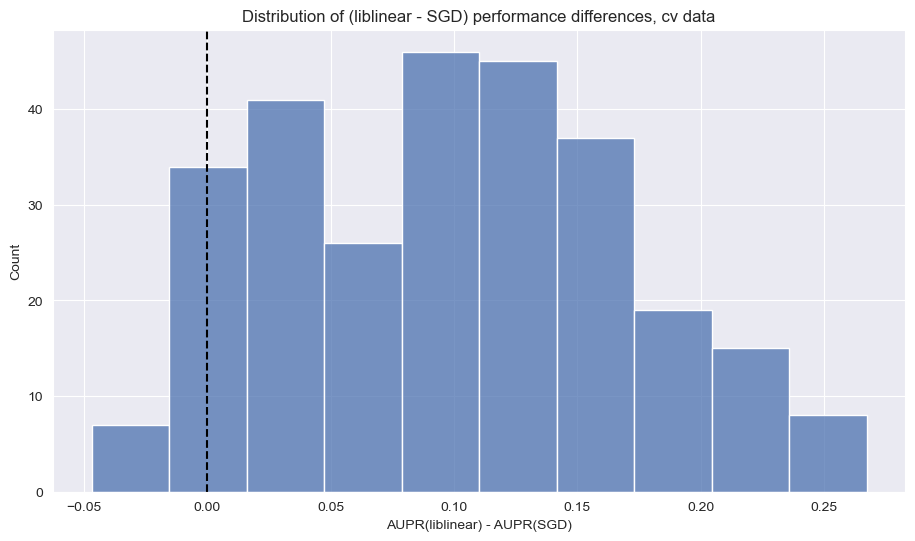

In [13]:
sns.set({'figure.figsize': (11, 6)})

sns.histplot(optimizer_diff_df.ll_sgd_diff)
plt.title(f'Distribution of (liblinear - SGD) performance differences, {data_type} data')
plt.xlabel('AUPR(liblinear) - AUPR(SGD)')
plt.gca().axvline(x=0, color='black', linestyle='--')

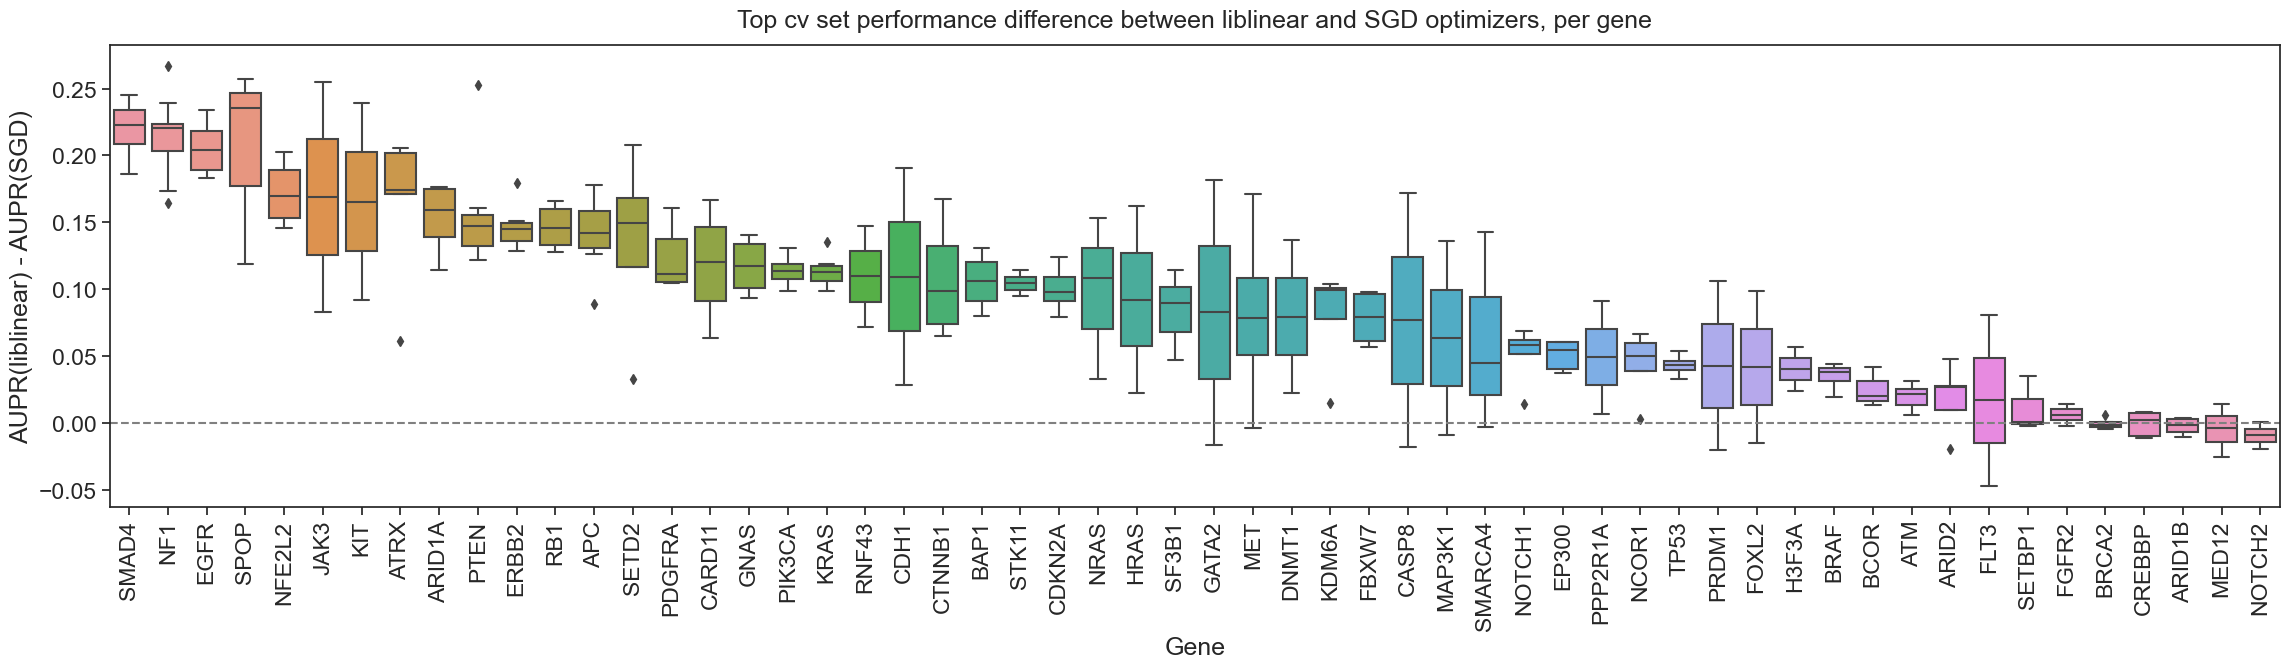

In [14]:
# plot test performance vs. number of nonzero features
sns.set({'figure.figsize': (28, 6)})
sns.set_style('ticks')

# order boxes by mean diff per gene
gene_order = (optimizer_diff_df
    .groupby('gene')
    .agg(np.mean)
    .sort_values(by='ll_sgd_diff', ascending=False)
).index.values

with sns.plotting_context('notebook', font_scale=1.5):
    ax = sns.boxplot(data=optimizer_diff_df, order=gene_order, x='gene', y='ll_sgd_diff')
    ax.axhline(0.0, linestyle='--', color='grey')
    plt.xticks(rotation=90)
    plt.title(f'Top {data_type} set performance difference between liblinear and SGD optimizers, per gene', y=1.02)
    plt.xlabel('Gene')
    plt.ylabel('AUPR(liblinear) - AUPR(SGD)')